# Identification of tau neutrinos with gradient tree boosting in the implementation XGBoost

## Loading in simulated neutrinos and seperating into training, validation, and testing data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import csv
import random   

#load data
trainingdf=pd.read_csv("trainingdata.csv")

#seperate signal from background
signalmask=trainingdf['y']==1
signaldf=trainingdf[signalmask]
backgrounddf=trainingdf[~signalmask]

#ordered selection of data from signal and background 
def selectorderly(signal, background,trainingpercent, trainingsample,testingpercent, testingsample):
    signal=signal.sample(frac=1, random_state=42).reset_index(drop=True)
    background=background.sample(frac=1, random_state=42).reset_index(drop=True)
    trainingdata =pd.concat([signal.iloc[0:int(trainingpercent*trainingsample)],background.iloc[0:int((1-trainingpercent)*trainingsample)]],ignore_index=True)
    testingdata= pd.concat([signal.iloc[int(trainingpercent*trainingsample):int(testingpercent*testingsample+trainingpercent*trainingsample)],background.iloc[int((1-trainingpercent)*trainingsample):int((1-testingpercent)*testingsample+(1-trainingpercent)*trainingsample)]],ignore_index=True)
    return trainingdata,testingdata


trainingsignalpercent=0.5
trainingsize=100000
testsignalpercent=len(signaldf)/(len(backgrounddf)+len(signaldf))
testsize=200000

trainingdf,testingdf=selectorderly(signaldf,backgrounddf,trainingsignalpercent,trainingsize,testsignalpercent,testsize)
X=trainingdf.drop('y',axis=1)
y=trainingdf['y']
#Creating training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=(0.2), random_state=42)

X_test=testingdf.drop('y',axis=1)
y_test=testingdf['y']



Training and comparing accuracy, signal efficiency, and purity between the logistic objective function and the hinge objective function XGBoost classifier. 

In [2]:
#Declaring XGBoost binary classifiers
logisticmodel = XGBClassifier(objective='binary:logistic', eval_metric='auc',early_stopping_rounds=50)
hingemodel =XGBClassifier(objective='binary:hinge', eval_metric='auc',early_stopping_rounds=50)
#train the model on the training data
logisticmodel.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=False)

hingemodel.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=False)
#make predictions on the test data
logisticmodel_pred = logisticmodel.predict(X_test)

hingemodel_pred=hingemodel.predict(X_test)

accuracy = accuracy_score(y_test, logisticmodel_pred)
from sklearn.metrics import precision_score, recall_score

#Results on the test data
print(f'Accuracy logistic: {accuracy}')
print(f'Precision logistic: {precision_score(y_test,logisticmodel_pred)}')
print(f'Recall logistic: {recall_score(y_test,logisticmodel_pred)}')
print(f'Accuracy hinge:{accuracy_score(y_test, hingemodel_pred)}')
print(f'Precision hinge: {precision_score(y_test,hingemodel_pred)}')
print(f'Recall hinge: {recall_score(y_test,hingemodel_pred)}')

Accuracy logistic: 0.8962494812474062
Precision logistic: 0.6020274847575728
Recall logistic: 0.852624725877193
Accuracy hinge:0.8947944739723699
Precision hinge: 0.5988684101891649
Recall hinge: 0.8450520833333334


Comparing quality of fit with different training data proportions

In [3]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

#testing various proportions 
propmodel=XGBClassifier(objective='binary:logistic',tree_method='hist', eval_metric='auc')
percent=0.1
while(percent<=.70):
    tempdf,_=selectorderly(signaldf,backgrounddf,percent,100000,testsignalpercent,testsize)
    X_temptrain=tempdf.drop('y',axis=1)
    y_temptrain=tempdf['y']
    propmodel.fit(X_temptrain,y_temptrain)
    tempmodel_pred=propmodel.predict(X_test)
    tempmodel_scores=propmodel.predict_proba(X_test)[:, 1]
    precision, recall, threshold = precision_recall_curve(y_test, tempmodel_scores)
    print(f'Signal {percent}: {accuracy_score(y_test, tempmodel_pred)}, {precision_score(y_test, tempmodel_pred)}, {recall_score(y_test, tempmodel_pred)}, {auc(recall, precision)}')
    if(percent==.1):
        percent=0.14
    elif(percent==0.14):
        percent=.20
    else:
        percent=percent+.10

Signal 0.1: 0.931959659798299, 0.8853537852548243, 0.6131099232456141, 0.8341761726627774
Signal 0.14: 0.9331296656483282, 0.8501506024096386, 0.6576548793859649, 0.8363713614681917
Signal 0.2: 0.9327546637733188, 0.8046466602129719, 0.7120339912280702, 0.8393725949531037
Signal 0.30000000000000004: 0.9268046340231701, 0.7368661042894831, 0.7752192982456141, 0.8400285904534938
Signal 0.4: 0.9149645748228741, 0.6710589160790043, 0.8184279057017544, 0.8399300931038836
Signal 0.5: 0.8966844834224171, 0.6031922881294354, 0.8533442982456141, 0.8376601744658174
Signal 0.6: 0.8737793688968445, 0.5408747613909868, 0.8932291666666666, 0.8434398312993486
Signal 0.7: 0.8339791698958495, 0.46544373001409756, 0.9276658442982456, 0.8424719755006888


Creating knn model to compare the performance of knn with XGBoost

In [4]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
knn_predict=knn.predict(X_test)
knn_score=knn.predict_proba(X_test)[:,1]
precision,recall,_=precision_recall_curve(y_test,knn_score)
print(f'Accuracy knn:{accuracy_score(y_test, knn_predict)}')
print(f'Precision knn: {precision_score(y_test,knn_predict)}')
print(f'Recall knn: {recall_score(y_test,knn_predict)}')
print(f'AUC knn: {auc(recall, precision)}')

Accuracy knn:0.8958844794223971
Precision knn: 0.6106625724647272
Recall knn: 0.7904673793859649
AUC knn: 0.7879668073212731


In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification


# Loop through mutliple models creating precision-recall curves
def precision_recall_curves_generator(models, names, filename):
    plt.figure()
    for model, name in zip(models,names):
        #take the probabilities of the model, that an entry *is* signal hence selecting [;,1]
        y_scores = model.predict_proba(X_test)[:, 1]
        #Calculate precision recall curve values (purity and signal efficiency)
        precision, recall, threshold = precision_recall_curve(y_test, y_scores)
        # Calculate the Area Under the Curve (AUC)
        # This provides a single-number summary of the model's performance
        pr_auc = auc(recall, precision)
        
        # Plot the precision-recall curve
        plt.step(recall, precision, where='post', lw=2, label=f'{name} (area = {pr_auc:.2f})')

    plt.xlim([0.65, 1])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Purity')
    plt.title('Precision Recall Curve')
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.savefig(filename + 'precision_recall.png')
    plt.yscale('log')
    plt.savefig(filename + 'precision_recalllog.png')

# Comparing the previous models to the best xgboost model
def precision_recall_curve_generator(model, name):
    dnn_purity=[0.1496167732944828, 0.16002240211801844, 0.18172897528098592, 0.20412405724372346, 0.2272048198672577,
     0.2500316461418832, 0.2730244202912949, 0.29525034868257455, 0.31610836003495485, 0.33615174529537206, 0.3551833516928345, 
     0.37314396384764364, 0.38974412008036874, 0.4061545616618867, 0.42173828504763755, 0.4358827396706057, 0.4512030088402257,
    0.4661656884793301, 0.48027564735363354, 0.49538151817787074, 0.5100298849633602, 0.5246410060327981, 0.5388032458821719,
    0.5527777777777778, 0.5664643327686806, 0.57988438744778, 0.5931935597130963, 0.6062957502392592, 0.6194872068514714,
    0.632346066056156, 0.6452855847688124, 0.6585658302626192, 0.6723585589941973, 0.6866954130733658, 0.7007337018003168,
    0.715688574588598, 0.7313017463299242, 0.746554779903787, 0.7630815596157469, 0.7799227799227799, 0.7976785492998472, 
    0.8162981625472395, 0.836500851318393, 0.8597431987012348, 0.8824591208324485, 0.9063716094557704, 0.9279261964251393, 
    0.9487382270472356, 0.9704705982469577, 0.9907788161993769]

    dnn_efficiency=[0.9996120613648386, 0.9976018338917299, 0.9927702345265386, 0.9869511549991183, 0.9815200141068594,
     0.9752424616469758, 0.9691765120789985, 0.9630752953623699, 0.9567977429024863, 0.9506259918885558, 0.9438194321989067,
    0.9376829483336272, 0.9303826485628637, 0.9239640275083759, 0.9179333450890496, 0.9119026626697232, 0.9054135073179334,
    0.8991712220067007, 0.8922235937224475, 0.8851701639922412, 0.8787515429377535, 0.8710280373831776, 0.8640804090989244,
    0.8562158349497443, 0.849127138070887, 0.8420031740433785, 0.8341738670428496, 0.8266619643801799, 0.8188679245283019,
    0.8109328160818198, 0.8032445776758949, 0.7941809204725798, 0.7845882560394992, 0.7750661259037207, 0.7645917827543643, 
    0.7530946922941281, 0.7413859989419855, 0.7279139481572915, 0.7143713630752954, 0.6981484746958209, 0.6810439076000705, 
    0.6627402574501852, 0.6410862281784517, 0.6163286898254277, 0.5862105448774466, 0.5503438546993475, 0.5108093810615412,
    0.46538529359901254, 0.402186563216364, 0.28040909892435195]
    # Take the probabilities of the model, that an entry *is* signal hence selecting [;,1]
    y_scores = model.predict_proba(X_test)[:, 1]
    knn_score=knn.predict_proba(X_test)[:,1]
    # Calculate precision recall curve values (purity and signal efficiency)
    precision, recall, threshold = precision_recall_curve(y_test, y_scores)
    knn_precision,knn_recall,_=precision_recall_curve(y_test, knn_score)
    # Calculate the precsion-recall Area Under the Curve (AUC)
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'{name}')
    
    plt.plot(dnn_efficiency,dnn_purity,color='red', lw=2, label=f'Tensorflow DNN ')
    plt.plot(knn_recall,knn_precision,color='darkgreen', lw=2, label=f'Scikit kNN ')
    plt.xlim([0.65, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Purity')
    plt.title('Precision Recall Curve')
    plt.legend(loc="upper right")
    plt.grid(False)
    plt.savefig(name + 'precision_recall.png')
    plt.show()


Binning out features of the data, and calculating the purity and efficiency of the respective bins. THe bins are then fed to plt histograms where the signal and background distribution with respect to those features are outlined. 

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def confusion_matrix_display(model, targets):
    model_results= model.predict(X_test)
    cm = confusion_matrix(targets, model_results)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()
    precision = precision_score(targets, model_results)
    recall = recall_score(targets, model_results)
    # Simple binomial confidence interval
    purity_error = 1 / (cm[1][1] + cm[0][1]) * np.sqrt(cm[1][1] * (1 - cm[1][1] / (cm[1][1] + cm[0][1]))) 
    eff_error = 1 / (cm[1][1] + cm[1][0]) * np.sqrt(cm[1][1] * (1 - cm[1][1] / (cm[1][1] + cm[1][0])))
    print(f'precision: {precision*100:0.2f} +- {purity_error*100:0.2f}')
    print(f'efficiency: {recall*100:0.2f} +- {eff_error*100:0.2f}')


from scipy.stats import binomtest


# Calculate biniomial proportion confidence interval (https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval), specifically Clopper–Pearson interval
def confusion_matrix_error(model_results,targets):
    cm = confusion_matrix(targets, model_results)
    tn, fp, fn, tp = cm.ravel()
    precision=precision_score(targets, model_results, zero_division=0)
    precisionerror=np.array(binomtest(tp, tp+fp).proportion_ci()[:])
    precisionerror=np.abs(precisionerror-[precision,precision])
    recall=recall_score(targets, model_results, zero_division=0)
    recallerror=np.array(binomtest(tp, tp+fn).proportion_ci()[:])
    recallerror=np.abs(recallerror-[recall,recall])
    return {'precision':precision,'precisionerror':precisionerror,'recall':recall,'recallerror':recallerror}


# Seperates out the features into bins and applies purities and efficiencies for those bins
def binning(model,n_bins,feature,range_hist,multiplier):
    custom = list(np.arange(range_hist[0],range_hist[1],(range_hist[1]-range_hist[0])/n_bins))
    analysis_df = X_test.copy()
    analysis_df['y_true'] = y_test
    analysis_df['y_pred'] = model.predict(X_test)
    analysis_df[feature]=multiplier*analysis_df[feature]
    analysis_df['bin'] = pd.cut(analysis_df[feature], bins=custom)
    # Group by the bins and calculate metrics
    binned_metrics = analysis_df.groupby('bin', observed=False).apply(
        lambda group: pd.Series({
            'count': len(group),
            'precision': confusion_matrix_error(group['y_true'], group['y_pred'])['precision'],
            'precisionerror':confusion_matrix_error(group['y_true'], group['y_pred'])['precisionerror'],
            'recall':confusion_matrix_error(group['y_true'], group['y_pred'])['recall'],
            'recallerror':confusion_matrix_error(group['y_true'], group['y_pred'])['recallerror']
        }),
    include_groups=False).reset_index()
    binned_metrics['center']=binned_metrics['bin'].apply(lambda x: x.mid)
    return binned_metrics


# Creates purity and signal efficiency histograms with signal and background distrubtion
def features_signal_efficiency(model, name, num_bins,feature):
    parameter_dict = {'ptot_p': [ 20, (0.29, 2.5), 'total momentum proton [GeV]', 1], 
                      'ptot_mu': [ 20, (0, 7), r'total momentum $\mu^-$ [GeV]', 1], 
                      'alpha': [ 20, (20, 160), r'angle $\alpha$ btween $\mu^-$ and $p$', 180 / np.pi], 
                      'theta': [ 20, (0, 90), r'angle $\theta$ between $\mu^-$ and $\nu$', 180 / np.pi],
                      'energy':[20,(0.5,8), r'total $\mu^-$ and proton energy [GeV]', 1]}
    hist_bins, hist_range, x_label, multiplier = parameter_dict[feature] 
    # Binning out 
    efficpurity=binning(logisticmodel,hist_bins,feature,hist_range,multiplier)
    total_test=X_test.copy()
    total_test['label']=y_test
    signal_test=total_test[total_test['label']==1]
    back_test=total_test[total_test['label']==0]


    fig, ax1 = plt.subplots()
    ax1.set_ylabel('N', color='tab:blue')
    ax1.set_xlabel(x_label)
    ax1.hist(signal_test[feature]*multiplier, bins=num_bins,range=hist_range, alpha=0.5, label='Signal', color='blue')
    ax1.hist(back_test[feature]*multiplier, bins=num_bins,range=hist_range, alpha=0.5, label='Background', color='red')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc="lower right")
    ax2 = ax1.twinx()
    
    ax2.set_ylabel('Purity', color='tab:red')
    ax2.errorbar(efficpurity['center'], efficpurity['precision'], linestyle = 'none', marker = 'o', color='tab:red', yerr = np.array(list(efficpurity['precisionerror'])).T)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim([0, 1])
    plt.xlim(hist_range)
    
    plt.savefig(f'{name}{feature}purity.png')
    plt.show()
    fig, ax1 = plt.subplots()
    ax1.set_ylabel('N', color='tab:blue')
    ax1.set_xlabel(x_label)
    ax1.hist(signal_test[feature]*multiplier, bins=num_bins,range=hist_range, alpha=0.5, label='Signal', color='blue')
    ax1.hist(back_test[feature]*multiplier, bins=num_bins,range=hist_range, alpha=0.5, label='Background', color='red')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc="lower right")
    ax2 = ax1.twinx()
    
    ax2.set_ylabel('Signal efficiency', color='tab:red')
    ax2.errorbar(efficpurity['center'], efficpurity['recall'], linestyle = 'none', marker = 'o', color='tab:red', yerr = np.array(list(efficpurity['recallerror'])).T)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim([0, 1])
    plt.xlim(hist_range)
    
    plt.savefig(f'{name}{feature}efficiency.png')
    plt.show()
    plt.close()

    

# Loops through the various features/parameters of the data
def figures_generator(model, num_bins,name):
    parameters=['ptot_p','ptot_mu', 'alpha', 'theta','energy']
    i=0
    while(i<len(parameters)):
        features_signal_efficiency(model,name,num_bins,parameters[i])
        i=i+1


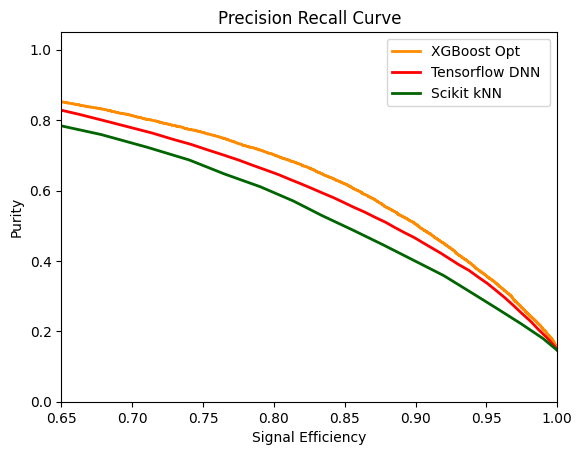

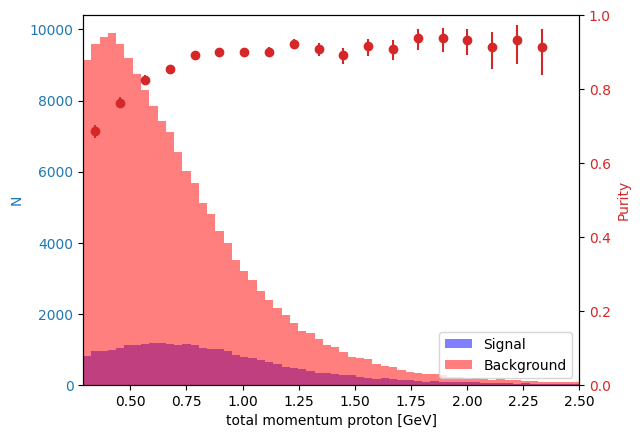

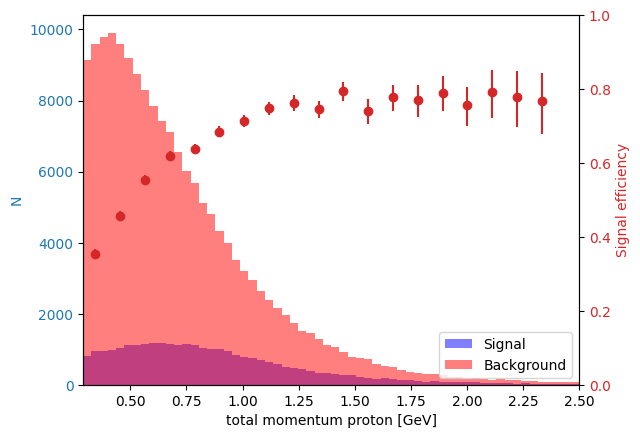

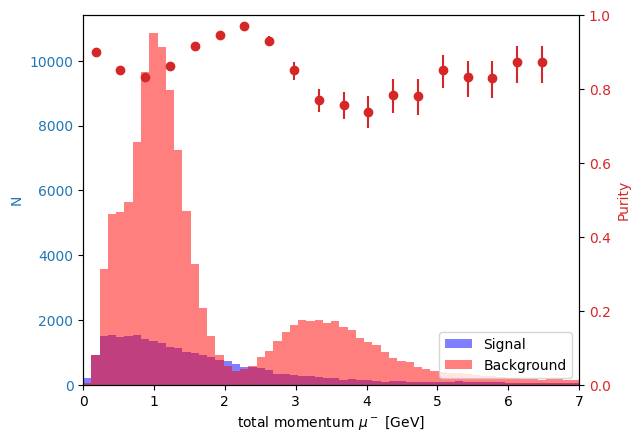

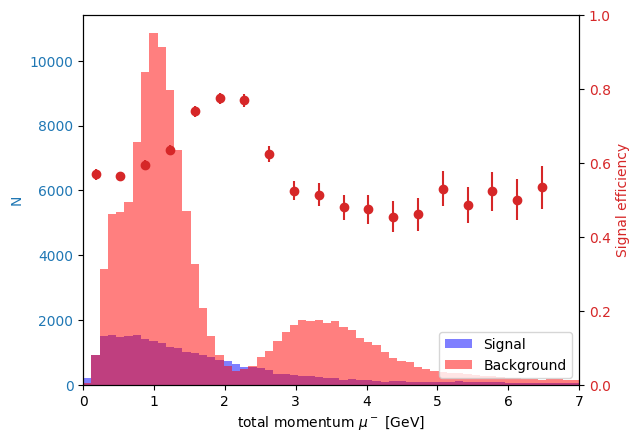

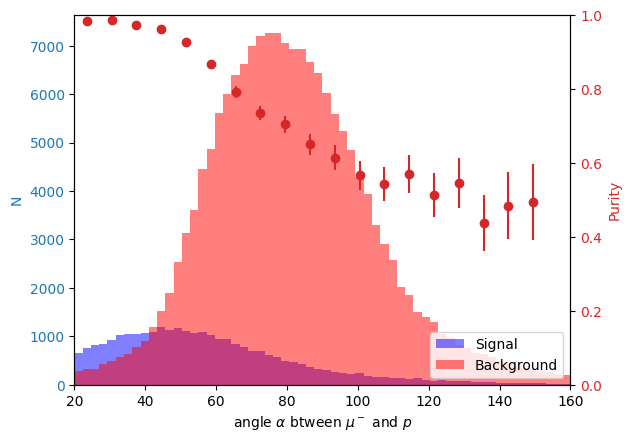

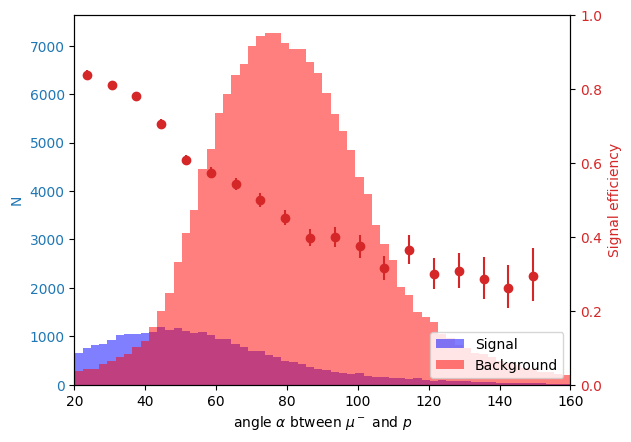

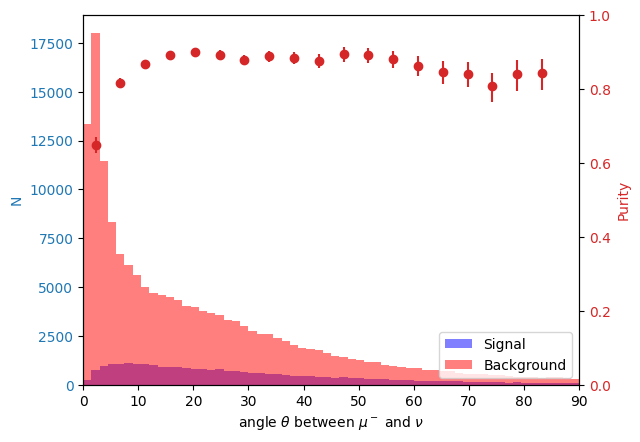

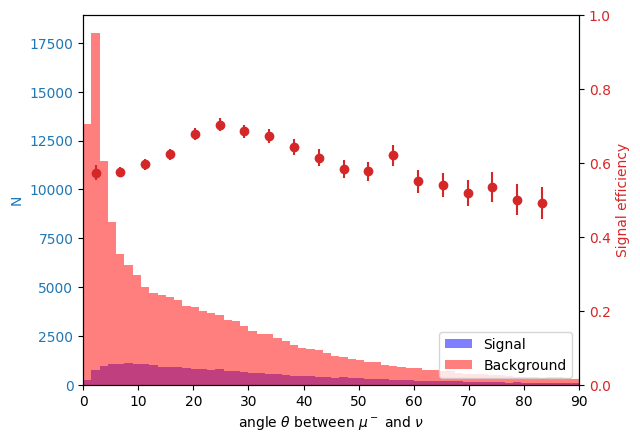

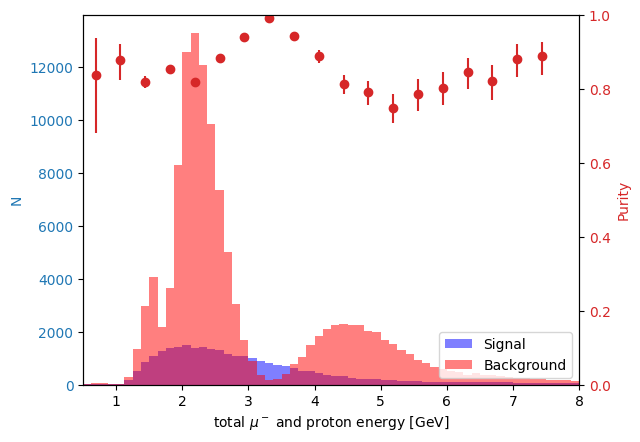

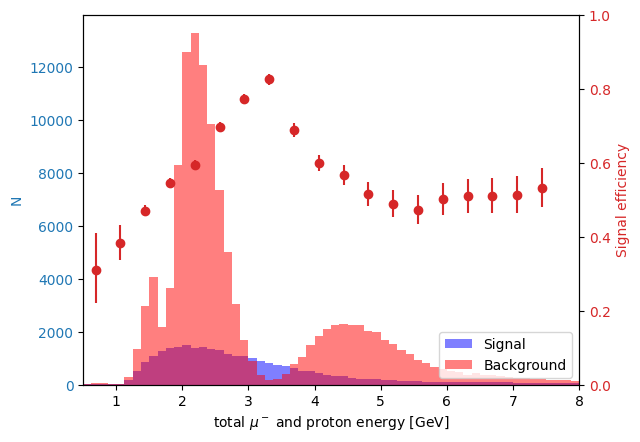

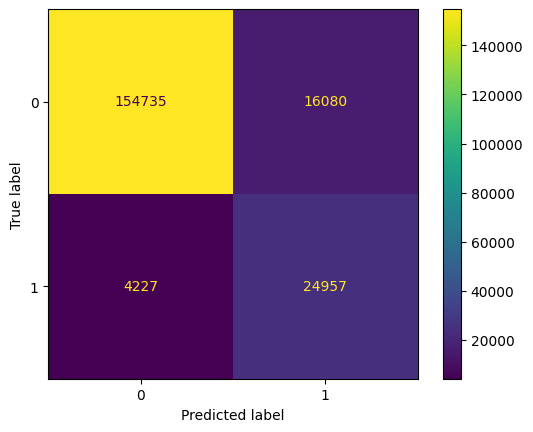

precision: 60.82 +- 0.24
efficiency: 85.52 +- 0.21


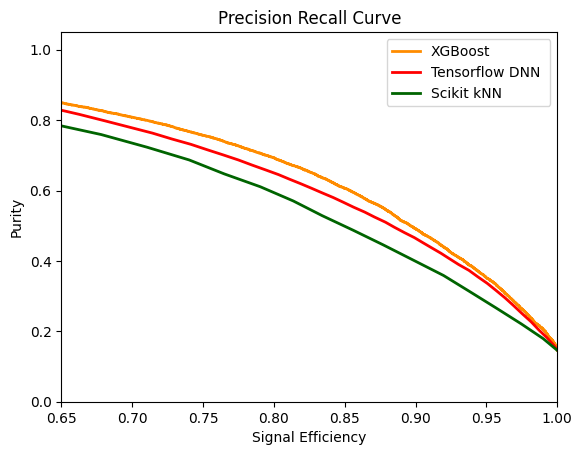

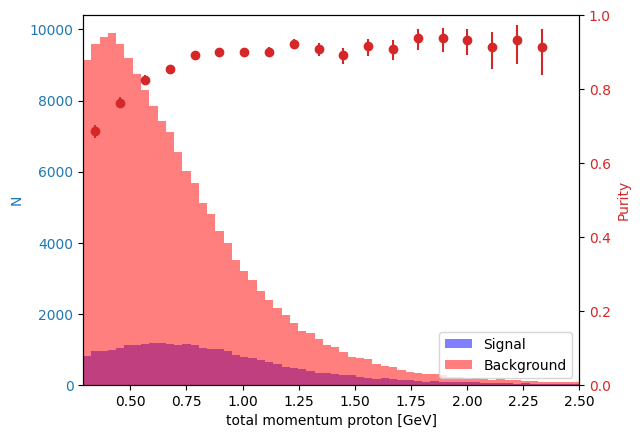

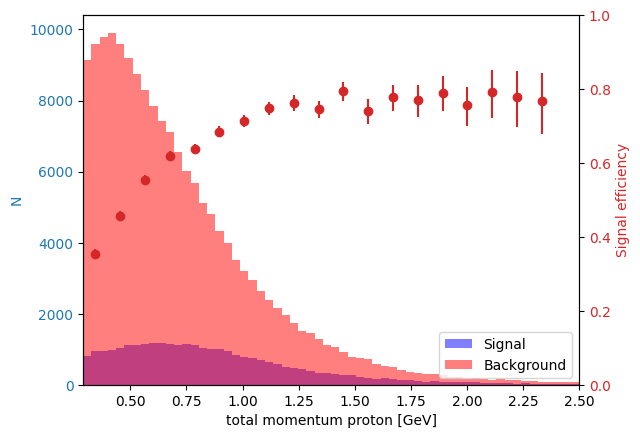

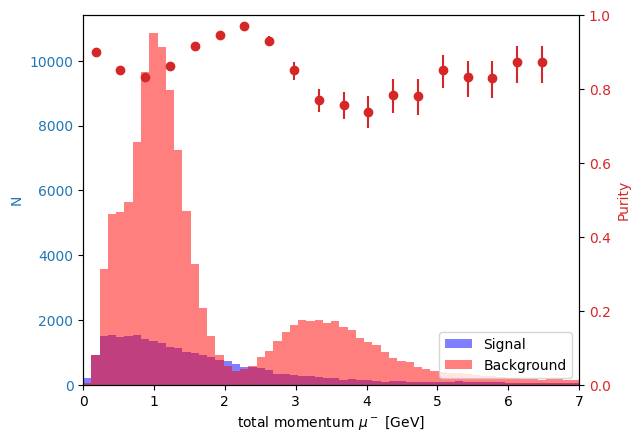

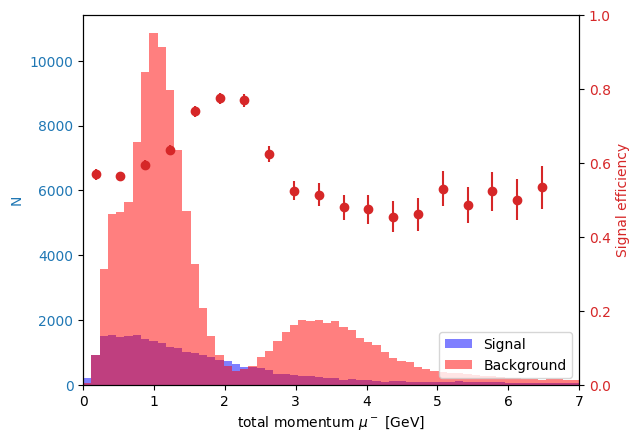

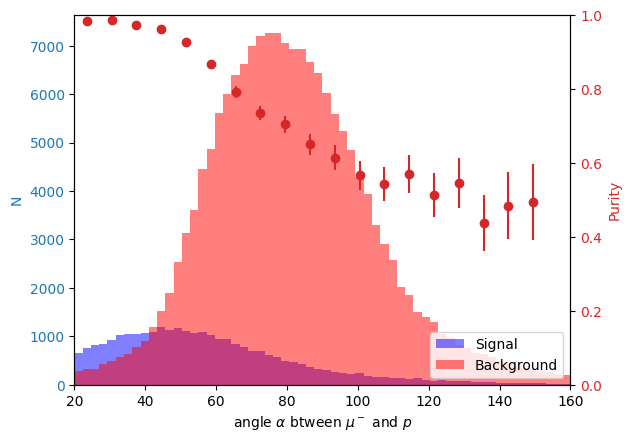

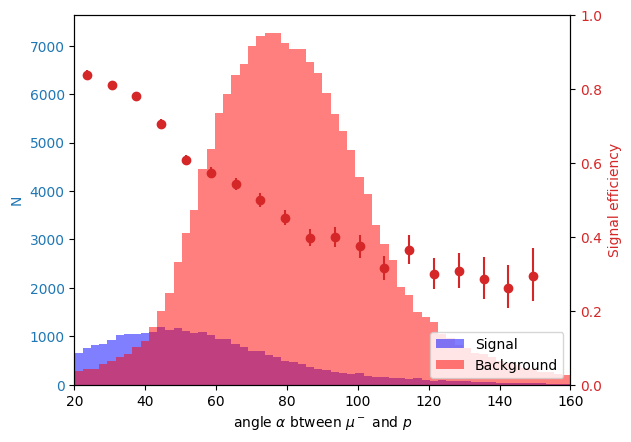

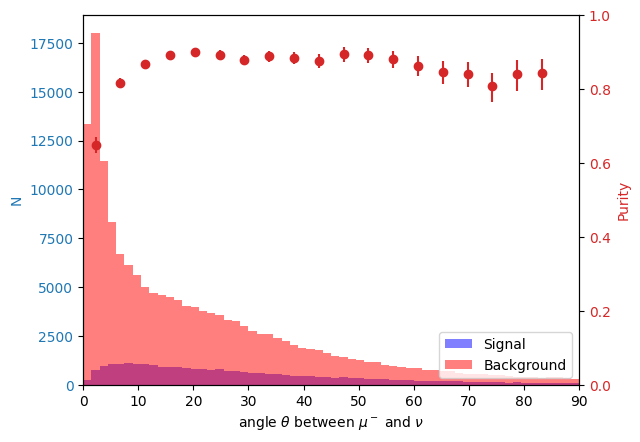

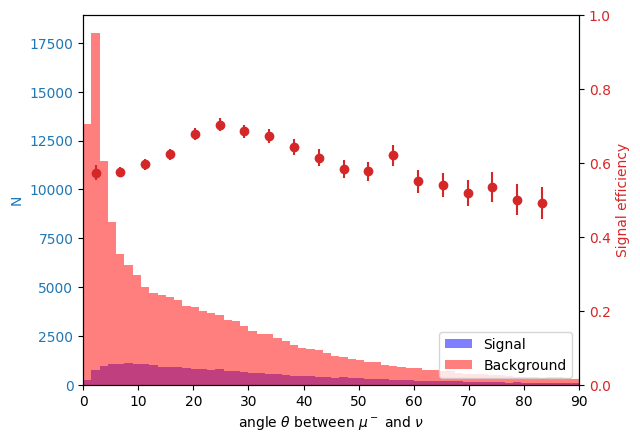

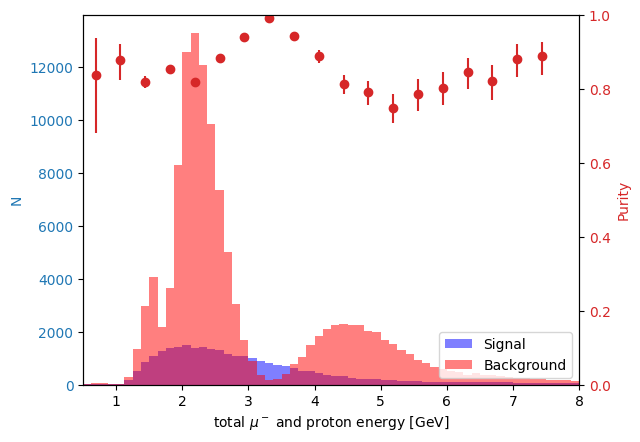

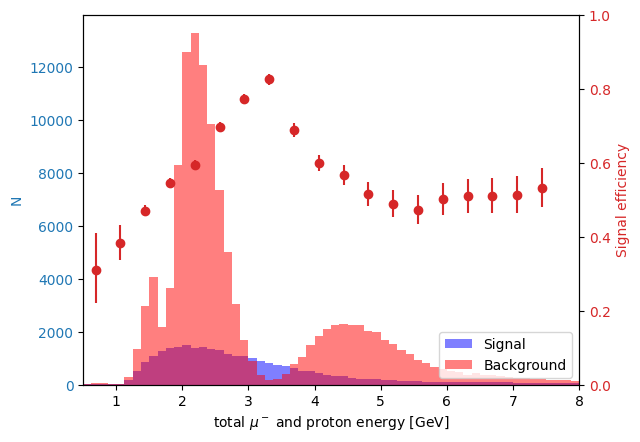

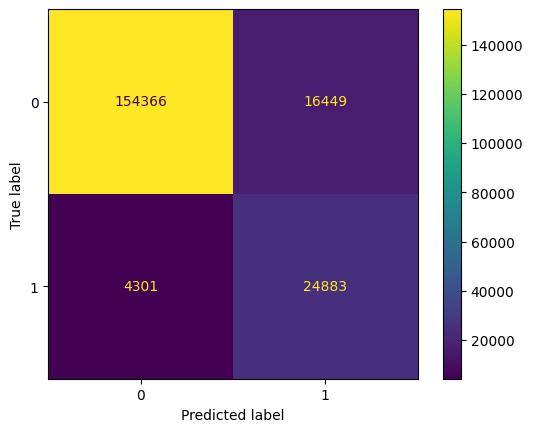

precision: 60.20 +- 0.24
efficiency: 85.26 +- 0.21


In [10]:
#optimized model
optparam = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "tree_method": "hist",
        'learning_rate': 0.06504856968981275,
        'n_estimators': 639}
optmodel = XGBClassifier(**optparam, random_state=42, early_stopping_rounds=50)
optmodel.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
#Figure generation
numberbins=60
precision_recall_curve_generator(optmodel,'XGBoost Opt')
figures_generator(optmodel,numberbins,'xgboostopt')
confusion_matrix_display(optmodel,y_test)



precision_recall_curve_generator(logisticmodel,'XGBoost')
figures_generator(logisticmodel,numberbins,'xgboost')
confusion_matrix_display(logisticmodel,y_test)